# DeepDetect (Binary) — Xception





### **Why Xception?**

We use **Xception** as an alternative backbone to ResNet50 for several reasons:

* **Depthwise separable convolutions:**  
  Xception is based on depthwise separable convolutions, which are very effective at capturing fine-grained local textures and artifacts.  
  This is useful for DeepFake detection, where subtle blending seams, local distortions, or texture inconsistencies can reveal manipulation.

* **Strong transfer learning performance:**  
  Xception comes with ImageNet pre-trained weights. By reusing these generic visual features and only adapting the top layers to our binary task,  
  we can reach strong performance even with a limited labelled dataset.

* **Fair architectural comparison:**  
  We keep the same data pipeline, image size, and training strategy as in the ResNet50 experiment.  
  This allows a fair, controlled comparison between two different architectures on exactly the same DeepFake dataset.

In the following sections, we reuse the same loading, preprocessing, and training setup as before,  
but we replace the ResNet50 backbone with Xception and observe how this affects accuracy and F1-score.



### **Setup and import dependencies**

In [1]:
import os, json, glob, shutil, zipfile, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')


print("TF:", tf.__version__)
print("Keras API:", keras.__version__)
print("NumPy:", np.__version__)


DATASET_SRC = DATASET_SRC = "/content/drive/MyDrive/archive.zip"
OUTPUT_DIR  = "/content/drive/MyDrive/deepdetect_outputs_xception"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Output dir:', OUTPUT_DIR)
!rm -rf /content/cache_*




Mounted at /content/drive
TF: 2.19.0
Keras API: 3.10.0
NumPy: 2.0.2
Output dir: /content/drive/MyDrive/deepdetect_outputs_xception


### **find and prepare the dataset folders for training, validation, and testing.**

In [2]:
def _children(d):
    return [n for n in os.listdir(d) if os.path.isdir(os.path.join(d, n))]

def _looks_like_split_root(d):
    names = [n.lower() for n in _children(d)]
    has_train = any('train' in n or 'training' in n for n in names)
    has_test  = any('test'  in n or 'testing'  in n for n in names)
    has_val   = any('val'   in n or 'valid'    in n for n in names)
    return (has_train and has_test) or (has_train and has_val)

def ensure_dataset_root(src_path):
    if os.path.isdir(src_path):
        root = src_path
    elif os.path.isfile(src_path) and src_path.lower().endswith('.zip'):
        target_root = '/content/dataset_unzipped'
        if os.path.exists(target_root):
            shutil.rmtree(target_root)
        os.makedirs(target_root, exist_ok=True)
        print(f"[INFO] Unzipping: {src_path} -> {target_root}")
        with zipfile.ZipFile(src_path, 'r') as z:
            z.extractall(target_root)
        root = target_root
    else:
        raise FileNotFoundError(f'Not found or unsupported: {src_path}')

    queue, visited, depth = [root], set(), {root: 0}
    while queue:
        p = queue.pop(0)
        if p in visited or depth[p] > 3:
            continue
        visited.add(p)
        if _looks_like_split_root(p):
            return p
        for c in _children(p):
            cp = os.path.join(p, c)
            depth[cp] = depth[p] + 1
            queue.append(cp)

    for c in _children(root):
        if c.lower() == 'dataset':
            return os.path.join(root, c)
    return root

def discover_split_names(root):
    name_map = {'train': None, 'val': None, 'test': None}
    for d in _children(root):
        low = d.lower()
        if ('train' in low or 'training' in low) and name_map['train'] is None:
            name_map['train'] = d
        elif ('val' in low or 'valid' in low or 'validation' in low) and name_map['val'] is None:
            name_map['val'] = d
        elif ('test' in low or 'testing' in low) and name_map['test'] is None:
            name_map['test'] = d
    if name_map['train'] is None or name_map['test'] is None:
        raise RuntimeError(f'Could not detect split folders under: {root}\nFound: {_children(root)}')
    return name_map

DATASET_DIR = ensure_dataset_root(DATASET_SRC)
SPLIT_NAME_MAP = discover_split_names(DATASET_DIR)
USE_VAL_DIR = SPLIT_NAME_MAP['val'] is not None
print('[INFO] DATASET_DIR =', DATASET_DIR)
print('[INFO] Splits map  =', SPLIT_NAME_MAP)
print('GPU:', tf.config.list_physical_devices('GPU'))

[INFO] Unzipping: /content/drive/MyDrive/archive.zip -> /content/dataset_unzipped
[INFO] DATASET_DIR = /content/dataset_unzipped/Dataset
[INFO] Splits map  = {'train': 'Train', 'val': 'Validation', 'test': 'Test'}
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **loads and prepares the image dataset by creating training, validation, and test splits from the detected folders.**

In [3]:
IMG_SIZE   = (224, 224)
BATCH_SIZE = 2
SEED       = 42
EPOCHS     = 15
STEPS_PER_EPOCH  = 4000
VALIDATION_STEPS = 250

def build_dataset(split):
    real = SPLIT_NAME_MAP[split]
    split_dir = os.path.join(DATASET_DIR, real)
    if split == 'train' and not USE_VAL_DIR:
        train_dir = os.path.join(DATASET_DIR, SPLIT_NAME_MAP['train'])
        ds_train = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir, labels='inferred', label_mode='int',
            image_size=IMG_SIZE, batch_size=BATCH_SIZE,
            validation_split=0.15, subset='training', seed=SEED)
        ds_val = tf.keras.preprocessing.image_dataset_from_directory(
            train_dir, labels='inferred', label_mode='int',
            image_size=IMG_SIZE, batch_size=BATCH_SIZE,
            validation_split=0.15, subset='validation', seed=SEED)
        return ds_train, ds_val
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        split_dir, labels='inferred', label_mode='int', image_size=IMG_SIZE,
        batch_size=BATCH_SIZE, shuffle=(split!='test'), seed=(SEED if split!='test' else None))
    return ds

if USE_VAL_DIR:
    train_ds = build_dataset('train')
    val_ds   = build_dataset('val')
else:
    train_ds, val_ds = build_dataset('train')
test_ds = build_dataset('test')

class_names = getattr(train_ds, 'class_names', None) or getattr(val_ds, 'class_names')
print('Classes:', class_names)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Classes: ['Fake', 'Real']


### Preview Dataset Samples

Before starting model training, we display a sample of images from each dataset split (training, validation, and testing).  
This helps verify that:
- Data is loaded correctly  
- Labels are mapped properly  
- Images are preprocessed correctly  


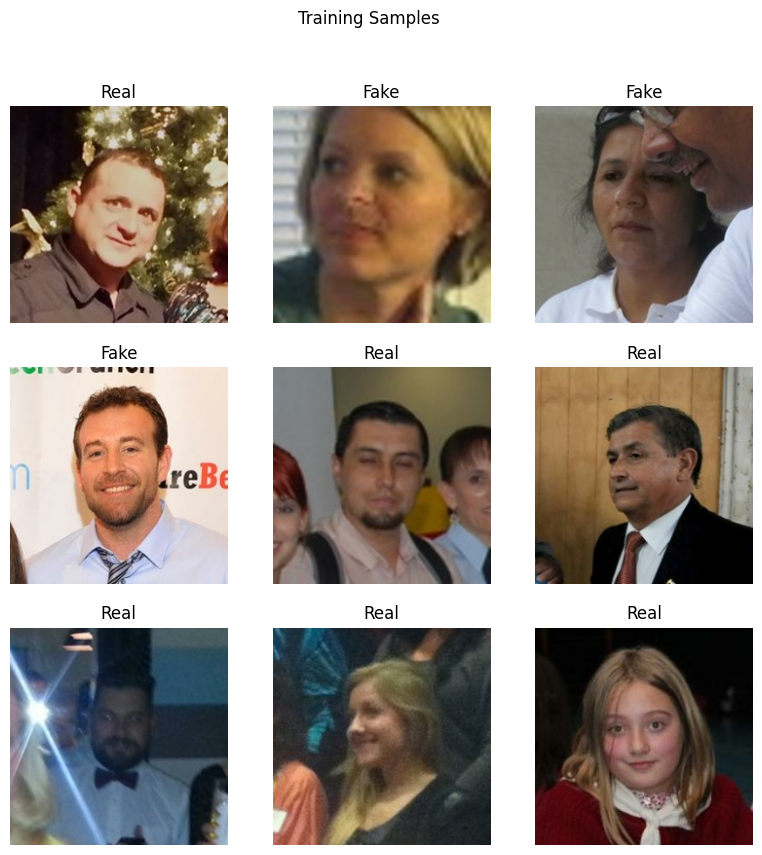

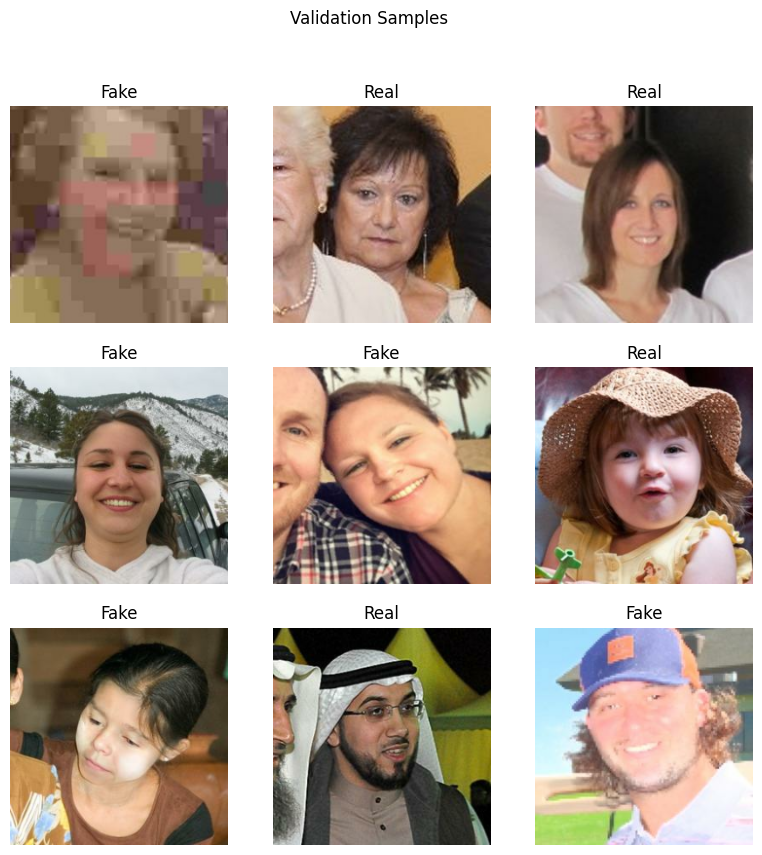

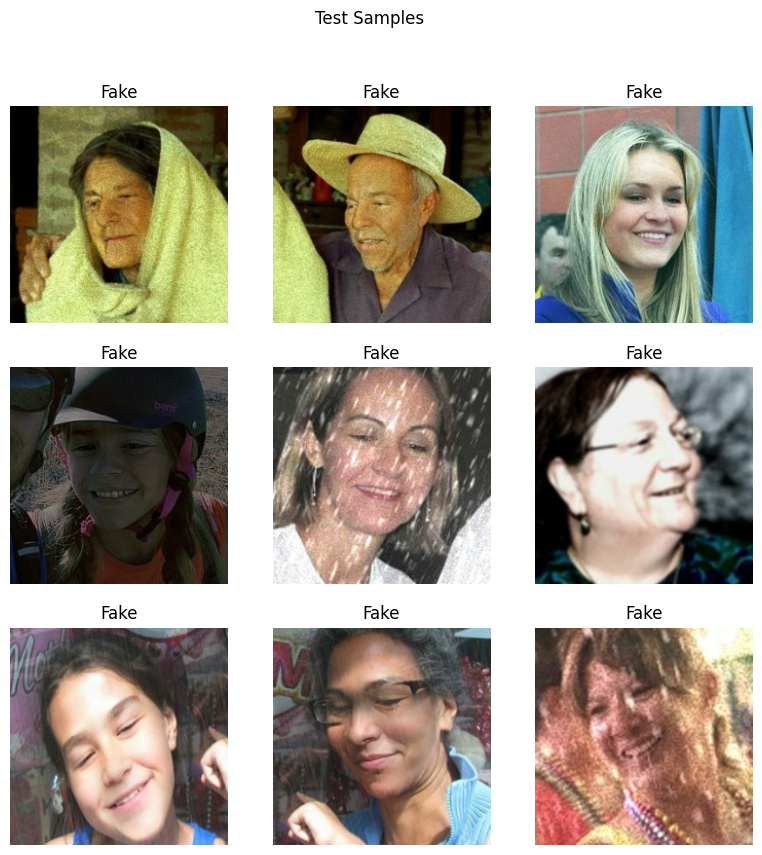

In [4]:

def _to_display_range(img):
    # (H,W,1) → (H,W)
    if img.ndim == 3 and img.shape[-1] == 1:
        img = img[..., 0]

    if img.dtype == np.uint8:
        return img

    img = img.astype(np.float32)
    vmin, vmax = float(img.min()), float(img.max())

    if vmin >= 0.0 and vmax <= 1.0:
        return img
    if vmin >= -1.0 and vmax <= 1.0:
        return (img + 1.0) / 2.0
    if vmax > 1.5:
        return img / 255.0

    return np.clip(img, 0.0, 1.0)

def show_samples(dataset, title, class_names, n=9):
    single = dataset.unbatch().take(n)

    imgs, labs = [], []
    for img, lab in single:
        imgs.append(img.numpy())
        labs.append(lab.numpy())

    if not imgs:
        print(f"[{title}] No samples to display.")
        return

    labs = np.array(labs)
    if labs.ndim > 1:
        labs = labs.argmax(axis=-1)

    k = len(imgs)
    cols = min(3, k)
    rows = int(np.ceil(k / cols))

    plt.figure(figsize=(cols * 3.2, rows * 3.2))
    for i in range(k):
        ax = plt.subplot(rows, cols, i + 1)
        img = _to_display_range(imgs[i])
        cmap = 'gray' if (img.ndim == 2) else None
        plt.imshow(img, cmap=cmap)
        plt.title(class_names[int(labs[i])])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()



class_names = train_ds.class_names

show_samples(train_ds, "Training Samples", class_names)
show_samples(val_ds, "Validation Samples", class_names)
show_samples(test_ds, "Test Samples", class_names)


### **optimize the TensorFlow data pipeline.**
It caches, shuffles, and prefetches images to speed up training and ensure smoother GPU performance  reducing loading delays and improving overall efficiency.


In [5]:
def cfg(ds, *, split, training=False):

    if training:
        ds = ds.shuffle(2048, reshuffle_each_iteration=True)

    ds = ds.prefetch(1)

    opt = tf.data.Options()
    opt.experimental_deterministic = False
    return ds.with_options(opt)

train_ds = cfg(train_ds, split='train', training=True)
val_ds   = cfg(val_ds,   split='val',   training=False)
test_ds  = cfg(test_ds,  split='test',  training=False)

print("Pipelines ready.")


Pipelines ready.


## **improveing speed and data diversity**
mixed precision (float16) to boost GPU performance and reduce memory use, and  **simple data augmentation** (flip, rotate, zoom) to help the model generalize better and prevent overfitting.

In [6]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
], name='augmentation')
print('Mixed precision & augmentation ready.')

Mixed precision & augmentation ready.


### **Build the DeepDetect Model using Xception**

We define a custom Binary F1 metric to capture the balance between precision and recall,
which is crucial for binary classification where the two classes (Fake vs Real) may be imbalanced.

Then, we construct the **DeepDetect** model by using **Xception** (pre-trained on ImageNet) as a feature extractor.
On top of the frozen backbone, we add:

* a `GlobalAveragePooling2D` layer to aggregate spatial features,
* a `Dropout` layer to reduce overfitting, and
* a final `Dense(1, activation='sigmoid')` output layer specialized for the real vs fake decision.

In the first stage, we keep the Xception backbone frozen and only train the new top layers.



In [7]:
class BinaryF1(keras.metrics.Metric):
    def __init__(self, threshold=0.5, name='f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        y_pred = tf.cast(tf.reshape(y_pred, [-1]) >= self.threshold, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1.0 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1.0 - y_pred))
        self.tp.assign_add(tp); self.fp.assign_add(fp); self.fn.assign_add(fn)
    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall    = self.tp / (self.tp + self.fn + 1e-8)
        return 2.0 * precision * recall / (precision + recall + 1e-8)
    def reset_state(self):
        for v in (self.tp, self.fp, self.fn): v.assign(0.0)

base = keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SIZE + (3,)
)
base.trainable = False  # freeze backbone for the first training stage

inputs = keras.Input(shape=IMG_SIZE + (3,))
# apply data augmentation on raw images
x = data_augmentation(inputs)
# Xception-specific preprocessing (scales pixels to the range expected by the backbone)
x = keras.applications.xception.preprocess_input(x)
# pass through the frozen Xception backbone
x = base(x, training=False)
# global pooling + dropout + final sigmoid classifier
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

model = keras.Model(inputs, outputs, name='DeepDetect_Xception')
model.summary()



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "DeepDetect_Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

The model summary now shows the **Xception-based DeepDetect architecture**.

Most of the parameters belong to the frozen Xception backbone (pre-trained on ImageNet),
while only a relatively small number of parameters in the new top layers (GlobalAveragePooling, Dropout, Dense) are trainable.

This design lets us:

* reuse strong, generic visual features learned by Xception, and  
* only train a light-weight classification head specialized for the DeepFake (real vs fake) task.

In the next step, we compile and train this model while keeping the backbone frozen,
then optionally fine-tune deeper layers later.



### **Compile Model and Set Callbacks**

 we compile the model using learning rate = 1e-4 and Binary Crossentropy as the loss function, which is ideal for binary classification.

We also include several evaluation metrics to get a complete view of model performance beyond accuracy alone.

To ensure stable and efficient training, three callbacks are configured:


*   **ModelCheckpoint:** saves the model only when it achieves the best validation F1 score.

*   **EarlyStopping:** stops training if validation performance stops improving to avoid overfitting.

*   **ReduceLROnPlateau:** lowers the learning rate when progress stalls, helping the model refine learning.











In [8]:
metrics = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           BinaryF1(name='f1', threshold=0.5)]

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=metrics)

ckpt_path = os.path.join(OUTPUT_DIR, 'best_xception.keras')
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_f1', mode='max', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]
print('Compiled. Callbacks ready.')


Compiled. Callbacks ready.


### **Train the model (frozen Xception backbone) with validation monitoring**

We now launch training on the `train_ds` pipeline while keeping the Xception backbone frozen.
The callbacks (Checkpoint, EarlyStopping, ReduceLROnPlateau) monitor the validation F1-score and validation loss:

* save the best Xception model based on **val_f1**,  
* stop training when progress stalls to avoid overfitting, and  
* reduce the learning rate when improvement slows down, helping the model refine its decision boundary.

This stage gives us a first baseline of how well the frozen Xception features work for the DeepFake task.



In [9]:
hist = model.fit(
    train_ds.repeat(),
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
3997/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5757 - f1: 0.6181 - loss: 0.6741 - precision: 0.5705 - recall: 0.6767
Epoch 1: val_f1 improved from -inf to 0.59406, saving model to /content/drive/MyDrive/deepdetect_outputs_xception/best_xception.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 104s 17ms/step - accuracy: 0.5758 - f1: 0.6181 - loss: 0.6741 - precision: 0.5705 - recall: 0.6767 - val_accuracy: 0.6720 - val_f1: 0.5941 - val_loss: 0.6032 - val_precision: 0.8571 - val_recall: 0.4545 - learning_rate: 1.0000e-04
Epoch 2/15
3997/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6960 - f1: 0.7052 - loss: 0.5857 - precision: 0.6977 - recall: 0.7138
Epoch 2: val_f1 improved from 0.59406 to 0.69011, saving model to /content/drive/MyDrive/deepdetect_outputs_xception/best_xception.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.6960 - f1: 0.7052 - loss: 0.5857 - precision: 0.6977 - recall: 0.7138 - val_accuracy: 0.7180 - val_f1: 0.6901 - val_loss: 0.5383 -

After training, we inspected the learning curves (loss, accuracy, F1).
We observed a fast improvement in the first few epochs as the model adapted to the dataset, followed by a more stable phase where validation metrics plateaued with small fluctuations.

The best validation F1 reached 0.74, and the gap between training and validation curves stayed small, indicating that the frozen Xception features were already effective for distinguishing real vs. fake images.

As training progressed, the learning-rate reductions helped refine performance, but no major improvements appeared after Epoch 10, suggesting that the model had largely converged.

### **Visualize Training Progress**

This function plots the training and validation curves for key metrics loss, accuracy, and F1 across all epochs. It helps visualize how well the model learned and whether it overfitted or underfitted.

Saved: /content/drive/MyDrive/deepdetect_outputs_xception/training_curves.png


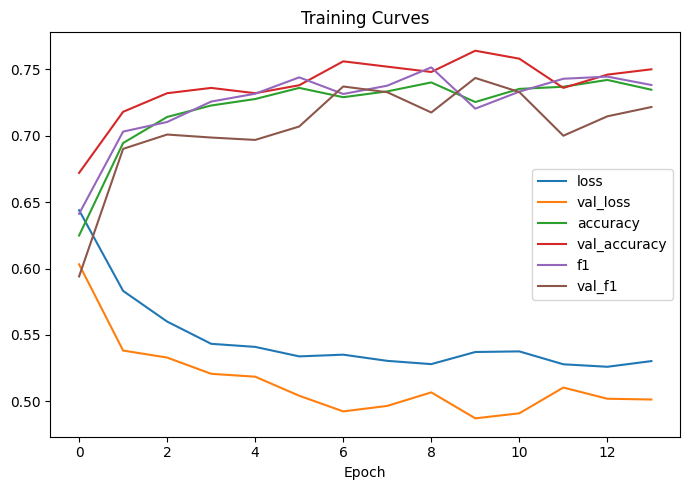

In [10]:
def plot_history(history, keys=("loss","val_loss","accuracy","val_accuracy","f1","val_f1")):
    fig, ax = plt.subplots(figsize=(7,5))
    for k in keys:
        if k in history.history:
            ax.plot(history.history[k], label=k)
    ax.set_xlabel('Epoch'); ax.set_title('Training Curves'); ax.legend(); fig.tight_layout()
    out = os.path.join(OUTPUT_DIR, 'training_curves.png'); fig.savefig(out, dpi=160)
    print('Saved:', out)
plot_history(hist)

The plotted curves show how the model improved over training. Loss decreased consistently across epochs, while accuracy and F1-score rose and stabilized around 0.72–0.74. The close alignment between training and validation curves indicates good generalization and that the model did not suffer from significant overfitting.

### **Test evaluation**

We evaluate how well the **Xception-based DeepDetect model** performs on the held-out test set.
This tells us how well the model can generalize to new images and distinguish between real and fake content.

The evaluation uses:

* standard scalar metrics (accuracy, precision, recall, F1), and  
* a confusion matrix and classification report  

to provide a detailed view of which class (real vs fake) is harder for the model and whether there is any systematic bias.




Classification Report (pre-FT):
              precision    recall  f1-score   support

        Fake     0.6565    0.8079    0.7243      5492
        Real     0.7455    0.5710    0.6467      5413

    accuracy                         0.6903     10905
   macro avg     0.7010    0.6895    0.6855     10905
weighted avg     0.7007    0.6903    0.6858     10905

Saved: /content/drive/MyDrive/deepdetect_outputs_xception/confusion_matrix_preFT.png


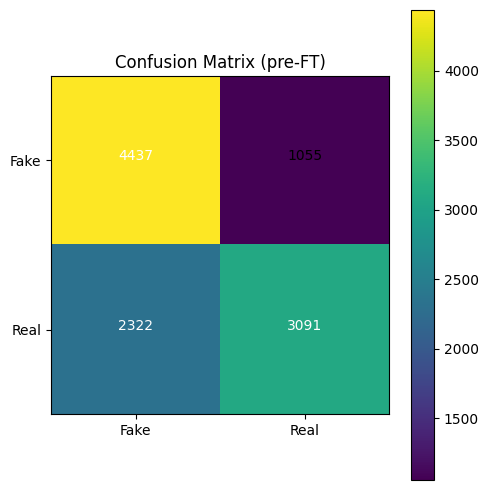

In [11]:
y_true, y_pred = [], []
for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel()
    y_true.extend(labels.numpy().tolist())
    y_pred.extend((probs >= 0.5).astype(int).tolist())
y_true = np.array(y_true); y_pred = np.array(y_pred)

print('\nClassification Report (pre-FT):')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (pre-FT)')
ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
th = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i,j], 'd'), ha='center', color=('white' if cm[i,j]>th else 'black'))
fig.colorbar(im); fig.tight_layout()
out = os.path.join(OUTPUT_DIR, 'confusion_matrix_preFT.png'); fig.savefig(out, dpi=160)
print('Saved:', out)

the confusion matrix summarizes the model’s performance on the test set with a 0.5 threshold. Overall accuracy is around 0.71. The model identifies most Fake samples correctly (4437 TP), but it also misclassifies some as Real (1055 FN). For the Real class, performance is weaker: many Real images are predicted as Fake (2322 FN), while 3091 are correctly detected (TP). This imbalance indicates a tendency toward predicting the Fake class more often, which aligns with the recall gap observed between the two classes.

Next steps to improve: fine-tune the backbone, consider class weights/imbalance handling.

### **Fine-tuning setup**

In the fine-tuning stage, we re-enable training for the deeper layers of the **Xception** backbone.

The idea is:

* keep the earlier convolutional blocks mostly frozen (they capture very general visual patterns), and  
* allow the later Xception blocks to adapt more specifically to DeepFake artifacts and face-related details.

We use a smaller learning rate in this phase to avoid destroying the useful pre-trained features,
while still giving the model enough flexibility to improve validation F1 on our dataset.



In [12]:
base.trainable = True
for layer in base.layers[:-80]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(3e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy'),
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       BinaryF1(name='f1', threshold=0.5)])
print('Fine-tune setup done.')

Fine-tune setup done.


### **Fine-tuning training run**

We continue training after unfreezing the top of Xception, using:

* a smaller learning rate,  
* a limited number of fine-tuning epochs, and  
* the same callbacks (ModelCheckpoint, ReduceLROnPlateau, EarlyStopping).

ModelCheckpoint keeps the best weights based on validation F1,
while ReduceLROnPlateau helps the optimizer converge more smoothly when progress slows down.

Because the datasets are streaming, we use `repeat()` with fixed `steps_per_epoch` / `validation_steps`
to keep each fine-tuning epoch bounded in time.



Epoch 1/4
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7460 - f1: 0.7518 - loss: 0.4954 - precision: 0.7411 - recall: 0.7642
Epoch 1: val_f1 improved from 0.74348 to 0.89200, saving model to /content/drive/MyDrive/deepdetect_outputs_xception/best_xception.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 199s 27ms/step - accuracy: 0.7461 - f1: 0.7518 - loss: 0.4954 - precision: 0.7411 - recall: 0.7642 - val_accuracy: 0.8920 - val_f1: 0.8920 - val_loss: 0.2689 - val_precision: 0.9370 - val_recall: 0.8511 - learning_rate: 3.0000e-05
Epoch 2/4
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9223 - f1: 0.9218 - loss: 0.1985 - precision: 0.9190 - recall: 0.9247
Epoch 2: val_f1 improved from 0.89200 to 0.92032, saving model to /content/drive/MyDrive/deepdetect_outputs_xception/best_xception.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 108s 27ms/step - accuracy: 0.9223 - f1: 0.9218 - loss: 0.1985 - precision: 0.9190 - recall: 0.9247 - val_accuracy: 0.9200 - val_f1: 0.9203 - val_loss: 0.2158

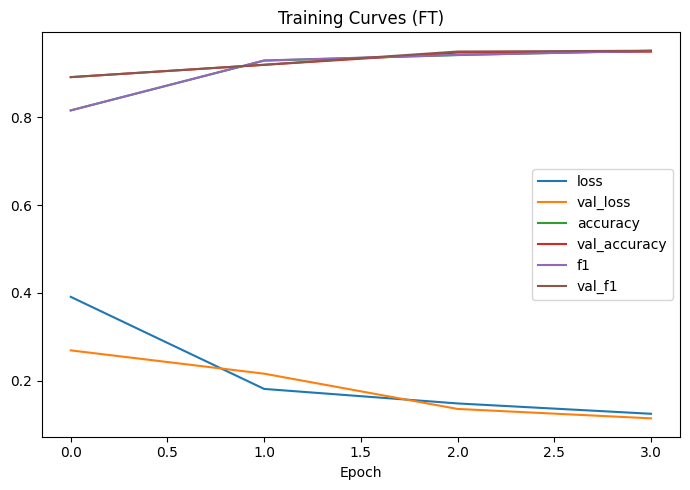

In [13]:
hist_ft = model.fit(
    train_ds.repeat(),
    validation_data=val_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=4,
    callbacks=callbacks,
    verbose=1
)
def plot_history_ft(history, keys=("loss","val_loss","accuracy","val_accuracy","f1","val_f1")):
    fig, ax = plt.subplots(figsize=(7,5))
    for k in keys:
        if k in history.history:
            ax.plot(history.history[k], label=k)
    ax.set_xlabel('Epoch'); ax.set_title('Training Curves (FT)'); ax.legend(); fig.tight_layout()
    out = os.path.join(OUTPUT_DIR, 'training_curves_ft.png'); fig.savefig(out, dpi=160)
    print('Saved:', out)
plot_history_ft(hist_ft)

After fine-tuning, the validation F1 score increased sharply from around 0.74 to 0.95, with validation accuracy rising to ~95%. Both loss and validation loss dropped quickly during the first epochs before stabilizing, indicating fast and smooth convergence. Training and validation curves remained closely aligned, showing no clear signs of overfitting. Overall, fine-tuning the deeper Xception layers significantly improved performance and refined the final decision boundary.

### **Final Evaluation**

evaluateing the fine-tuned model on the test dataset to assess its real-world performance.


FINAL Test Report (after FT):
              precision    recall  f1-score   support

        Fake     0.8457    0.9253    0.8837      5492
        Real     0.9163    0.8287    0.8703      5413

    accuracy                         0.8774     10905
   macro avg     0.8810    0.8770    0.8770     10905
weighted avg     0.8807    0.8774    0.8771     10905

Saved: /content/drive/MyDrive/deepdetect_outputs_xception/confusion_matrix_postFT.png
Artifacts saved to: /content/drive/MyDrive/deepdetect_outputs_xception


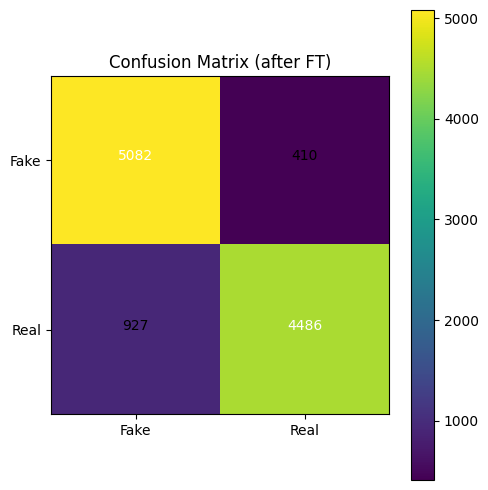

In [14]:
y_true, y_pred = [], []
for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel()
    y_true.extend(labels.numpy().tolist())
    y_pred.extend((probs >= 0.5).astype(int).tolist())
y_true = np.array(y_true); y_pred = np.array(y_pred)

print('\nFINAL Test Report (after FT):')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Confusion Matrix (after FT)')
ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names); ax.set_yticklabels(class_names)
th = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i,j], 'd'), ha='center', color=('white' if cm[i,j]>th else 'black'))
fig.colorbar(im); fig.tight_layout()
out = os.path.join(OUTPUT_DIR, 'confusion_matrix_postFT.png'); fig.savefig(out, dpi=160)
print('Saved:', out)

model.save(os.path.join(OUTPUT_DIR, 'final_model.keras'))
with open(os.path.join(OUTPUT_DIR, 'labels.json'), 'w') as f:
    json.dump({'classes': class_names}, f, indent=2)
with open(os.path.join(OUTPUT_DIR, 'test_metrics.json'), 'w') as f:
    json.dump({'accuracy': float(accuracy_score(y_true, y_pred)),
               'precision': float(precision_score(y_true, y_pred)),
               'recall': float(recall_score(y_true, y_pred)),
               'f1': float(f1_score(y_true, y_pred)),
               'confusion_matrix': cm.tolist()}, f, indent=2)
print('Artifacts saved to:', OUTPUT_DIR)

Real classes gained higher F1-scores (0.8837 and 0.8703), and the confusion matrix shows fewer misclassifications overall, particularly for the Real class, which previously had weaker recall. These gains indicate that unfreezing the upper Xception layers allowed the model to capture more discriminative DeepFake features.
At the same time, the balance between precision and recall remained stable, suggesting that the improvements did not come at the cost of overfitting. Overall, the fine-tuned model demonstrates stronger generalization and more reliable performance on the full test set.

###  Sample Model Predictions (Real vs Fake)

Below are random prediction samples from the **Test** and **Validation** datasets.
Each image is labeled as:
**Predicted : True**  
Green = Correct prediction  
Red = Wrong prediction


In [15]:
from tensorflow import keras

model_path = "/content/drive/MyDrive/deepdetect_outputs_xception/best_xception.keras"
model = keras.models.load_model(model_path, compile=False)

print("Model loaded:", model_path)




Model loaded: /content/drive/MyDrive/deepdetect_outputs_xception/best_xception.keras


In [16]:
import math

try:
    _to_display_range
except NameError:
    def _to_display_range(img):
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img[..., 0]
        img = img.astype("float32")
        return np.clip(img, 0, 1)

def _ensure_probs(pred):
    pred = np.array(pred)
    if pred.ndim == 2 and pred.shape[1] == 1:  # binary
        p1 = pred[:, 0]
        return np.stack([1 - p1, p1], axis=1)
    return pred  # multiclass ready

def display_predictions(dataset, model, class_names, n=24, cols=8,
                        title_mode="name", save_png=False, png_name="predictions.png"):
    imgs, labs = [], []
    for img, lab in dataset.unbatch().take(n):
        imgs.append(img.numpy())
        labs.append(lab.numpy())
    labs = np.array(labs)
    if labs.ndim > 1:
        labs = labs.argmax(axis=-1)

    x = np.stack(imgs, axis=0)
    raw_pred = model.predict(x, verbose=0)
    probs = _ensure_probs(raw_pred)
    pred_idx = probs.argmax(axis=1)

    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 2.2, rows * 2.2))

    for i in range(n):
        disp = _to_display_range(imgs[i])
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(disp, cmap="gray" if disp.ndim == 2 else None)
        correct = pred_idx[i] == labs[i]
        if title_mode == "name":
            title = f"{class_names[pred_idx[i]]} : {class_names[labs[i]]}"
        plt.title(title, color=("green" if correct else "red"))
        plt.axis("off")

    if save_png:
        plt.savefig(png_name, dpi=200, bbox_inches="tight")
    plt.show()


**Display Sample Validation Results**

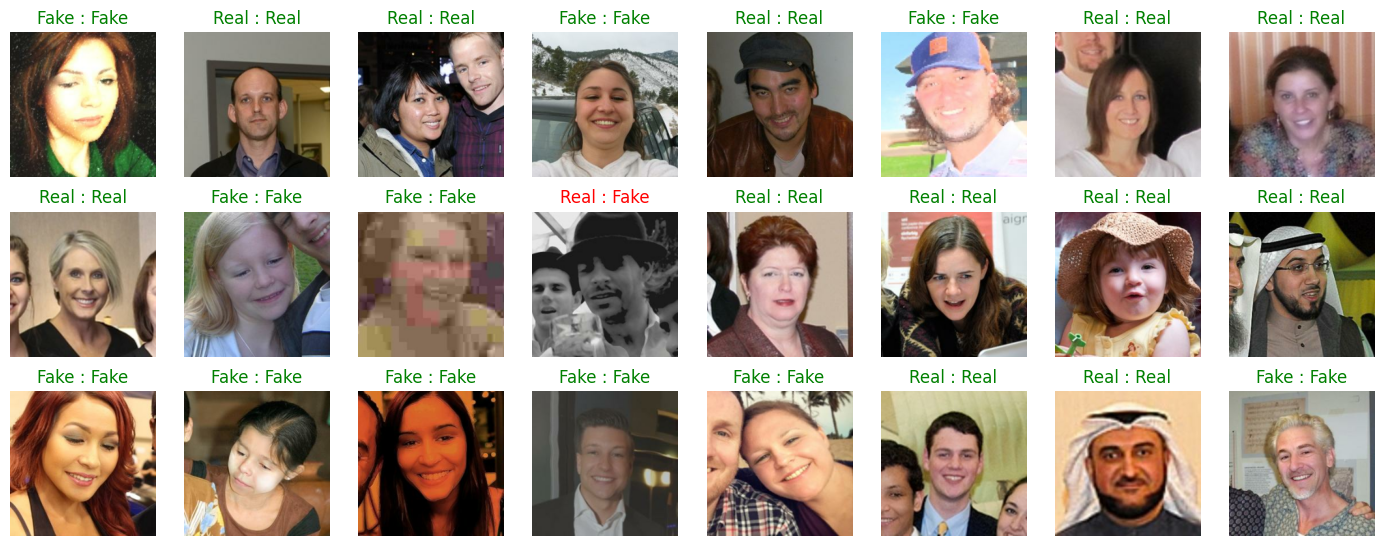

In [18]:
# validation dataset
display_predictions(
    val_ds,
    model,
    class_names=class_names,
    n=24,
    cols=8,
    title_mode="name",
    save_png=True,
    png_name="val_predictions_grid.png"
)

plt.show()


**Display Sample Test Results**

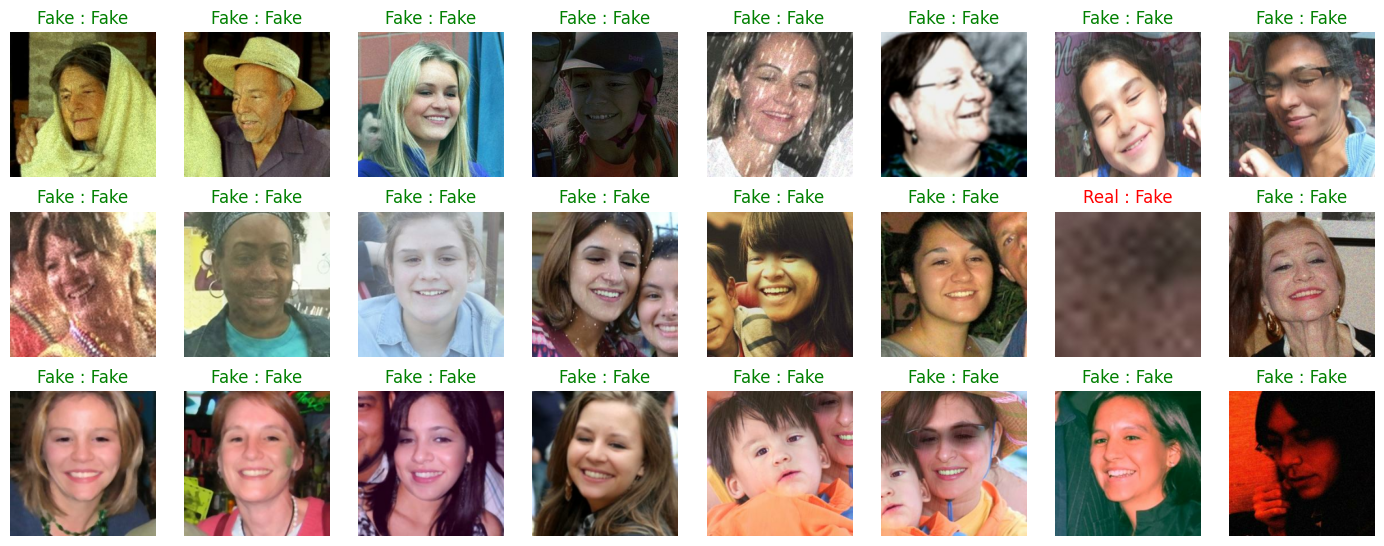

In [20]:
# test dataset
display_predictions(
    test_ds,
    model,
    class_names=class_names,
    n=24, cols=8, title_mode="name",
    save_png=True, png_name="test_predictions_grid.png"
)
plt.show()


### **Grad-CAM Visualization for Model Interpretability**

we used Grad-CAM (Gradient-weighted Class Activation Mapping) to visually explain how the model makes its predictions. Grad-CAM highlights the specific regions in an image that most influenced the model’s decision. in this case, whether an image is real or fake. By computing gradients of the output class score with respect to the convolutional feature maps, the method produces a heatmap overlay showing areas of high importance (in red/yellow) and less influence (in blue).

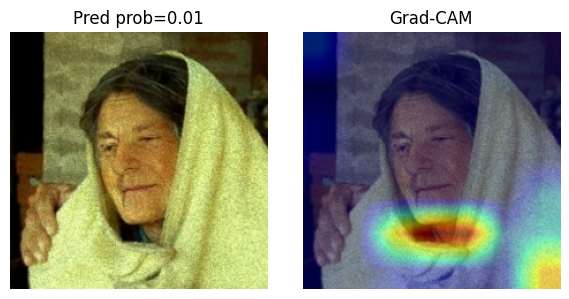

Saved: /content/drive/MyDrive/deepdetect_outputs_xception/gradcam_example.png


In [22]:


def grad_cam(
    img_tensor,
    model,
    backbone_name="xception",
    preprocess_fn=tf.keras.applications.xception.preprocess_input,
):

    aug_layer   = model.get_layer("augmentation")
    backbone    = model.get_layer(backbone_name)
    gap_layer   = next(l for l in model.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D))
    drop_layer  = next(l for l in model.layers if isinstance(l, tf.keras.layers.Dropout))
    dense_orig  = next(l for l in model.layers if isinstance(l, tf.keras.layers.Dense))


    dense_new = tf.keras.layers.Dense(
        units=dense_orig.units,
        activation=dense_orig.activation,
        dtype="float32",
        name="dense_cam_tmp",
    )
    dense_new.build((None, backbone.output_shape[-1]))
    dense_new.set_weights(dense_orig.get_weights())

    with tf.GradientTape() as tape:
        x = aug_layer(img_tensor, training=False)
        x = preprocess_fn(x)
        conv_out = backbone(x, training=False)

        x2 = gap_layer(conv_out)
        x2 = drop_layer(x2, training=False)
        preds = dense_new(x2)


        loss = preds[:, 0]


    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_out), axis=-1).numpy()[0]
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)


    cam = tf.image.resize(cam[..., None], img_tensor.shape[1:3]).numpy()[..., 0]
    return cam



for batch_imgs, _ in test_ds.take(1):
    img0  = batch_imgs[0:1]
    prob  = model.predict(img0, verbose=0)[0, 0]
    cam   = grad_cam(img0, model)
    img_d = img0[0].numpy().astype("uint8")

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img_d)
    plt.title(f"Pred prob={prob:.2f}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_d)
    plt.imshow(cam, alpha=0.45, cmap="jet")
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.tight_layout()
    out = os.path.join(OUTPUT_DIR, "gradcam_example.png")
    plt.savefig(out, dpi=160)
    plt.show()
    print("Saved:", out)
    break


Final Test Performance Summary

The final evaluation on the unseen test set shows that the fine-tuned Xception model achieves strong and well-balanced performance across both classes:

* Overall accuracy: 0.8774

* F1-score (Fake): 0.8837

* F1-score (Real): 0.8703

Precision and recall are well aligned, indicating that the model does not strongly favor one class over the other.

The confusion matrix further supports this balance:

The model correctly identified 5082 Fake images and 4486 Real images.

Misclassifications remain relatively limited (410 Fakes predicted as Real, 927 Reals predicted as Fake).

The strong diagonal dominance reflects reliable classification performance.


Overall, the improvements achieved after fine-tuning reflect a stronger and more confident separation between real and fake images, highlighting the effectiveness of the Xception model in this task.